<a href="https://colab.research.google.com/github/st148385/ACDC_3D_2Dslices/blob/main/2D_nnU_Net_ACDC_TopBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Packages for Google Colab

In [ ]:
# Import basic packages for later use
import os
import shutil
from collections import OrderedDict

import json
import matplotlib.pyplot as plt
import nibabel as nib

import numpy as np
import torch

In [ ]:
# check whether GPU accelerated computing is available
assert torch.cuda.is_available() # if there is an error here, enable GPU in the Runtime

# 2. Installing nnU-Net

In [ ]:
# due to problems with the dataset with newest simple ITK version preinstall a special version
# for more information about this see: https://github.com/MIC-DKFZ/nnUNet/issues/756
!pip install SimpleITK==2.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install nnunet - yes it is that easy
!pip install nnunet 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


**Note**: you do not have to restart the Runtime even when the following error appears, this is simply due to a reinstallation of a package - so no worries. 


```
WARNING: The following packages were previously imported in this runtime:

[argparse]

You must restart the runtime in order to use newly installed versions.
```

# 3. Verifying installation of nn-Unet

In [ ]:
# check if nnunet can be imported
import nnunet


You should read the following if the installation was successful:


```
Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

```



## 3.1 Installation and initialization of Weights&Biases (non-mandatory)
This is a package which allows you to easily visualize metrics during your training.

We will use this here to get access to System Information (GPU utilization etc.)when running on Google Colab - however it is also useful to use at a local workstation.

To use Weights&Biases you will need an account.
This can be created at https://wandb.ai

During the initialization with ```wandb.init()``` it will ask you for an API key, which you can obtain from:
https://wandb.ai/settings 
under API keys

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
wandb.init(project="nnU-Net_Workshop")

### 3.2 Installation of GDOWN (only for in-person workshops)
GDown allows to download files from GoogleDrive with Python.
Therefore it is used for in-person workshops.

In [ ]:
# install gdown to download files from GoogleDrive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 4. Connect Google Colab with GoogleDrive
This is heavily encouraged when using Google Colab, otherwise loading, accessing and saving of data checkpoints etc. is just much harder (if not impossible).

**Note**:
When ```drive.mount()``` is executed, there will appear a popup window, which will ask you which Google Account should be connected and then for permission regarding Colab accessing your GoogleDrive.

There can be some problems at this step, for me the solution was to Download the GoogleDrive Application.
You can download it from: https://www.google.com/drive/download/


If there are any problems at this stage, feel free to contact me (during the workshop).

In [ ]:
# for colab users only - mounting the drive

from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
base_dir = os.getcwd()

Mounted at /content/drive


In [ ]:
assert os.path.exists(drive_dir) # if this fails, something went wrong with mounting GoogleDrive
if os.path.exists(mount_dir) is False:
    os.makedirs(mount_dir)

# 5. Setting up nnU-Nets folder structure and environment variables
nnUnet expects a certain folder structure and environment variables. 

Roughly they tell nnUnet:
1. Where to look for stuff
2. Where to put stuff

For more information about this please check: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/setting_up_paths.md

In [ ]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

## 5.1 Set environment Variables and creating folders

In [ ]:
# Maybe move path of preprocessed data directly on content - this may be significantly faster!
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw_data_base" : os.path.join(mount_dir, "nnUNet_raw_data_base"), 
    "nnUNet_preprocessed" : os.path.join(mount_dir, "nnUNet_preprocessed"), # 1 experiment: 1 epoch took 112s
    # "nnUNet_preprocessed" : os.path.join(base_dir, "nnUNet_preprocessed"), # 1 experiment: 1 epoch took 108s -> seems faster take this
    "RESULTS_FOLDER" : os.path.join(mount_dir, "nnUNet_Results_Folder"),
    "RAW_DATA_PATH" : os.path.join(mount_dir, "RawData"), # This is used here only for convenience (not necessary for nnU-Net)!
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path 

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

print("If No Error Occured Continue Forward. =)")

Current Working Directory /content
/content/drive/My Drive/Colab Notebooks/nnUNet_raw_data_base exists.
/content/drive/My Drive/Colab Notebooks/nnUNet_preprocessed exists.
/content/drive/My Drive/Colab Notebooks/nnUNet_Results_Folder exists.
/content/drive/My Drive/Colab Notebooks/RawData exists.
If No Error Occured Continue Forward. =)


# 7. How to train and use nnU-Net on a new Dataset $\rightarrow$ ACDC?

Goal of the next Steps:
- How can you Implement nnU-Net for a new Dataset?
  - Example using the GM Spinal Cord Segmentation Challenge Dataset
    - [Data & Task Explanation](https://www.sciencedirect.com/science/article/pii/S1053811917302185)
    - [Data Download Link](http://cmictig.cs.ucl.ac.uk/niftyweb/challenge/)
- How to store the Data for use with nnU-Net?
  - General Information can be found [here](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/dataset_conversion.md)
- How to create the Data Fingerprint?
- How to create the Pipeline Fingerprint based on Rules?

This part of the Tutorial based on: 

The [GoogleColab Notebook](https://github.com/prateekgupta891/nnUNet/blob/master/nnunetmec2020.ipynb) and the [Medium Article about nnU-Net](https://medium.com/miccai-educational-initiative/nnu-net-the-no-new-unet-for-automatic-segmentation-8d655f3f6d2a)
written in the context of the MICCAI Educational Initiative.

In [ ]:
# Create Folderstructure for the new task!
task_name = 'Task902_ACDC_2D' #change here for different task name
nnunet_raw_data = os.path.join(os.getenv("nnUNet_raw_data_base"), "nnUNet_raw_data")
# nnunet_raw_data = "nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_raw_data,task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
test_dir = os.path.join(task_folder_name,'imagesTs')
# main_dir = os.path.join(base_dir,'nnUNet/nnunet')

# Create Folder Structure for the ACDC Task on the system
make_if_dont_exist(task_folder_name)
make_if_dont_exist(train_image_dir)
make_if_dont_exist(train_label_dir)
make_if_dont_exist(test_dir)

training_data_name="training-data-ACDC_2D"
test_data_name="test-data-ACDC_2D"

/content/drive/My Drive/Colab Notebooks/nnUNet_raw_data_base/nnUNet_raw_data/Task902_ACDC_2D exists.
/content/drive/My Drive/Colab Notebooks/nnUNet_raw_data_base/nnUNet_raw_data/Task902_ACDC_2D/imagesTr exists.
/content/drive/My Drive/Colab Notebooks/nnUNet_raw_data_base/nnUNet_raw_data/Task902_ACDC_2D/labelsTr exists.
/content/drive/My Drive/Colab Notebooks/nnUNet_raw_data_base/nnUNet_raw_data/Task902_ACDC_2D/imagesTs exists.


## 7.2 Data Preprocessing

Eigener file renaming code

In [ ]:
print(os.getcwd())

### Editiere Benennung der Traningsbilder ###
trainingImagesFolder = os.path.join(task_folder_name, "imagesTr")

os.chdir(trainingImagesFolder)

for file in os.listdir(trainingImagesFolder):
    print(file)
    os.rename(file, file.replace('_frame01_2D.nii.gz', '_frame01_0000.nii.gz'))
    #os.rename(file, file.replace('_frame01_0000.nii.gz', '_frame01.nii.gz'))


### Editiere Benennung <der Labels> (von den Traningsbildern) ###
trainingLabelsFolder = os.path.join(task_folder_name, "labelsTr")

os.chdir(trainingLabelsFolder)

for file in os.listdir(trainingLabelsFolder):
    print(file)
    os.rename(file, file.replace('_gt_2D', ''))


### Editiere Benennung der Testbilder ###
testImagesFolder = os.path.join(task_folder_name, "imagesTs")

os.chdir(testImagesFolder)

for file in os.listdir(testImagesFolder):
    print(file)
    os.rename(file, file.replace('_frame01_2D.nii.gz', '_frame01_0000.nii.gz'))


### Gehe zurück ins aktuelle "working directory" (cwd = current working directory) ###
os.chdir('/content/drive/My Drive/Colab Notebooks')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks
patient023_frame01_0000.nii.gz
patient024_frame01_0000.nii.gz
patient025_frame01_0000.nii.gz
patient026_frame01_0000.nii.gz
patient027_frame01_0000.nii.gz
patient028_frame01_0000.nii.gz
patient029_frame01_0000.nii.gz
patient030_frame01_0000.nii.gz
patient031_frame01_0000.nii.gz
patient032_frame01_0000.nii.gz
patient033_frame01_0000.nii.gz
patient034_frame01_0000.nii.gz
patient035_frame01_0000.nii.gz
patient001_frame01_0000.nii.gz
patient002_frame01_0000.nii.gz
patient003_frame01_0000.nii.gz
patient004_frame01_0000.nii.gz
patient005_frame01_0000.nii.gz
patient006_frame01_0000.nii.gz
patient007_frame01_0000.nii.gz
patient008_frame01_0000.nii.gz
patient009_frame01_0000.nii.gz
patient010_frame01_0000.nii.gz
patient011_frame01_0000.nii.gz
patient012_frame01_0000.nii.gz
patient013_frame01_0000.nii.gz
patient014_frame01_0000.nii.gz
patient015_frame01_0000.nii.gz
patient016_frame01_0000.nii.gz
patient017_frame01_0000.nii.gz
patient018_frame01_0000.nii.gz


## 7.3 Verification of Data

Before going any further, verify that the data is present and labels and data matches.

In [ ]:
train_files = os.listdir(train_image_dir)
label_files = os.listdir(train_label_dir)
print(f"Folders are {train_image_dir} for training images \nand {train_label_dir} for their (ground truth) labels")
print("train image files:",len(train_files))
print("train label files:",len(label_files))
#print("Matches:",len(set(train_files).intersection(set(label_files)))) # Es gibt 0 matches wenn ich die modalties (bei trainingsbildern endet der Dateiname mit 0000 oder 0001 (im Falle von 2 modalties) usw.)

#assert len(set(train_files).intersection(set(label_files))) == 35 #should be equal to 160 for SCGM Challenge

Folders are /content/drive/My Drive/Colab Notebooks/nnUNet_raw_data_base/nnUNet_raw_data/Task902_ACDC_2D/imagesTr for training images 
and /content/drive/My Drive/Colab Notebooks/nnUNet_raw_data_base/nnUNet_raw_data/Task902_ACDC_2D/labelsTr for their (ground truth) labels
train image files: 35
train label files: 35


## 7.4 Creation of the Task902 for 2D Slices of the ACDC Dataset
The Task gives nnU-Net Information for the Planning and Preprocessing Step.

Based on the parameters of the task, the "optimal strategy" is selected (data fingerprint & pipeline fingerprint)

This is done by creating the ```dataset.json``` file.




In [ ]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exists!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name
    json_dict['description'] = "Automated Cardiac Diagnosis Challenge (ACDC)"
    json_dict['tensorImageSize'] = "2D"  # Vorsicht: Vmtl muss ich hier 2D einstellen um die 2D Segmentation 2D nnUNet auszuführen.
    json_dict['reference'] = "see challenge website"
    json_dict['licence'] = "see challenge website"
    json_dict['release'] = "0.0"

    #you may mention more than one modality
    json_dict['modality'] = {
        "0": "MRI"
    }
    # Groundtruth label field images were created where 0, 1, 2 and 3 represent voxels located in the background, in the RV cavity, in the myocardium, and in the LV cavity. 
    # (Siehe https://www.creatis.insa-lyon.fr/Challenge/acdc/evaluation.html)

    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "0": "voxels in the background",
        "1": "voxels in the RV cavity",
        "2": "voxels in the myocardium",
        "3": "voxels in the LV cavity"
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)

    #no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    #removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]

    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json created!


## 7.5 Dataset Preprocessing
Also to ensure that nnU-Net can be trained on the dataset a integrity check is performed.

In [ ]:
# verify that the dataset will work & create plans - this may take about 11 minutes
!nnUNet_plan_and_preprocess -t 902 --verify_dataset_integrity



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case patient017_frame01
checking case patient025_frame01
checking case patient024_frame01
checking case patient022_frame01
checking case patient018_frame01
checking case patient021_frame01
checking case patient023_frame01
checking case patient019_frame01
checking case patient020_frame01
checking case patient026_frame01
checking case patient027_frame01
checking case patient028_frame01
checking case patient029_frame01
checking case patient030_frame01
checking case patient031_frame01
checking case patient003_frame01
checking case patient001_frame01
checking case patient033_frame01
checking case patient

## 7.6 Dataset Visualization
At this stage it is useful to examine the training and testing data.

Here is an example for how to do this in python, however we would encourage you to visualize the data with MITK-Workbench, since it allows much more interaction with the data and therefore better understanding.

Train Data (with Labels)

(208, 256) (208, 256)


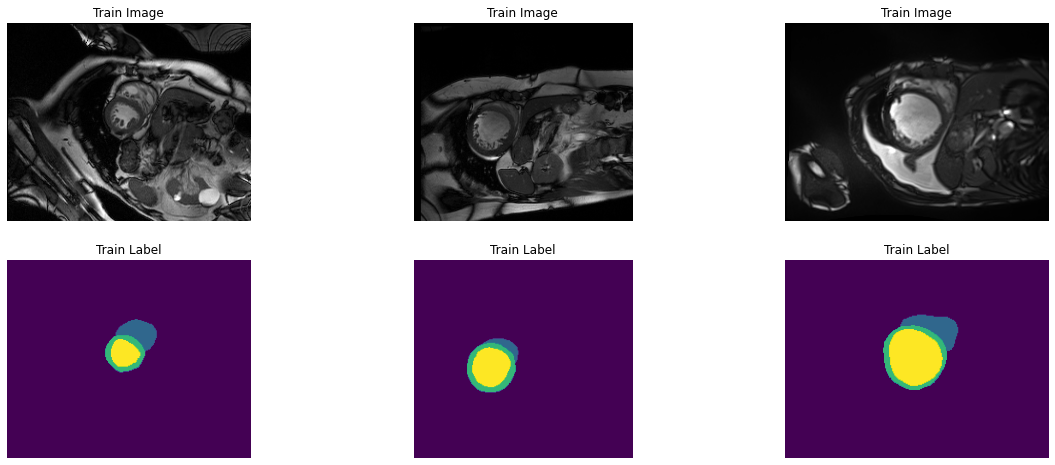

In [ ]:
#visualizing some of the training images and labels
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted
max_rows = 2
max_cols = 3

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))

train_img_name = os.listdir(train_image_dir)[np.random.randint(0,15)]
train_img = np.array(nib.load(os.path.join(train_image_dir,train_img_name)).dataobj)

train_label_name = train_img_name[:train_img_name.find('_0000.nii.gz')]+'.nii.gz'
train_label = np.array(nib.load(os.path.join(train_label_dir,train_label_name)).dataobj)

print(train_img.shape,train_label.shape)


axes[0,0].axis("off") 
axes[0,0].set_title('Train Image')
axes[0,0].imshow(train_img, cmap="gray")

axes[1,0].axis("off")
axes[1,0].set_title('Train Label')
axes[1,0].imshow(train_label)

train_img_name = os.listdir(train_image_dir)[np.random.randint(16,25)]
train_img = np.array(nib.load(os.path.join(train_image_dir,train_img_name)).dataobj)

train_label_name = train_img_name[:train_img_name.find('_0000.nii.gz')]+'.nii.gz'
train_label = np.array(nib.load(os.path.join(train_label_dir,train_label_name)).dataobj)

axes[0,1].axis("off") 
axes[0,1].set_title('Train Image')
axes[0,1].imshow(train_img, cmap="gray")

axes[1,1].axis("off")
axes[1,1].set_title('Train Label')
axes[1,1].imshow(train_label)

train_img_name = os.listdir(train_image_dir)[np.random.randint(26,35)]
train_img = np.array(nib.load(os.path.join(train_image_dir,train_img_name)).dataobj)

train_label_name = train_img_name[:train_img_name.find('_0000.nii.gz')]+'.nii.gz'
train_label = np.array(nib.load(os.path.join(train_label_dir,train_label_name)).dataobj)

axes[0,2].axis("off") 
axes[0,2].set_title('Train Image')
axes[0,2].imshow(train_img, cmap="gray")

axes[1,2].axis("off")
axes[1,2].set_title('Train Label')
axes[1,2].imshow(train_label)

#plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

~~Note: In the label image, yellow color represents white Matter and green-ish color represents grey matter.~~

Vermutlich jeweils Voxels in: \\
Purple = Background (Label 0) \\
Yellow = RV cavity (Label 1) \\
Green = Myocardium (Label 2) \\
Blue = LV cavity (Label 3) \\

"0": "voxels in the background",
        "1": "voxels in the RV cavity",
        "2": "voxels in the myocardium",
        "3": "voxels in the LV cavity"

Test Data (without Labels)

(248, 256)


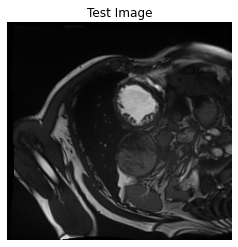

In [ ]:
# skip this due to non-existent data

#visualizing some of the test images
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted

test_img_name = os.listdir(test_dir)[np.random.randint(1,10)]
test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,:]

print(test_img.shape)

plt.imshow(test_img[:,:], cmap="gray")
plt.axis('off')
plt.title('Test Image')

plt.show()

### 7.6.1 Sighting of Data and Lables with MITK-Workbench
At this stage it is also useful to analyze the imaging data with MITK-Workbench.
To do this, download the training data to your own local machine and visualize them via drag and drop into MITK-Workbench

This is already explained in part 6.3.4

## 7.7 Training nnU-Net

nnU-Net stores a checkpoint every 50 epochs. If you need to continue a previous training, just add a -c to the training command.

Generic Training Commands:

```nnUNet_train CONFIGURATION TRAINER_CLASS_NAME TASK_NAME_OR_ID FOLD (additional options)```

For 2D:  ```nnUNet_train 2d nnUNetTrainerV2 TaskXXX_MYTASK FOLD```

For 3D Full resolution: ```nnUNet_train 3d_fullres nnUNetTrainerV2 TaskXXX_MYTASK FOLD```

For Cascaded 3D:

First Run lowres: ```nnUNet_train 3d_lowres nnUNetTrainerV2 TaskXXX_MYTASK FOLD```

Then Run fullres: ```nnUNet_train 3d_cascade_fullres nnUNetTrainerV2CascadeFullRes TaskXXX_MYTASK FOLD```

Regarding the loss:
Dice loss ranges from 0 to -1 and CE (cross entropy) from INF to 0. The best loss is -1. The worst is $∞$. \\
Quelle: Fabian Isensee https://github.com/MIC-DKFZ/nnUNet/issues/16

In [ ]:
# train nnU-Net with 3d_fullres model on the SCGM Task with Fold 0
# Again Training may take a while therefore it is advised to interrupt the training after some time (e.g. after 1 epoch)
# 1 Epoch takes approximately: over 30 minutes on GoogleColab -- you need GoogleColab Pro to run this completely
!nnUNet_train 2d nnUNetTrainerV2 902 0



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Traceback (most recent call last):
  File "/usr/local/bin/nnUNet_train", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.8/dist-packages/nnunet/run/run_training.py", line 137, in main
    trainer_class = get_default_configuration(network, task, network_trainer, plans_identifier)
  File "/usr/local/lib/python3.8/dist-packages/nnunet/run/default_configuration.py", line 47, in get_default_configuration
    plans = load_pickle(plans_file)
  File "/usr/local/lib/python3.8/dist-packages/batchgenerators/utilities/file_and_folder_operations.py", line 57, in load_pickle
    with open(file, mode) as f:
FileNotFoundEr

## 7.8 Inference Code

nnUNet_find_best_configuration will print inference commands you need to use. The easiest way to run inference is to simply use these commands.

For each of the desired configurations, run:

```nnUNet_predict -i INPUT_FOLDER -o OUTPUT_FOLDER -t TASK_NAME_OR_ID -m CONFIGURATION --save_npz```

Only specify ```--save_npz``` if you intend to use ensembling. ```--save_npz``` will make the command save the softmax probabilities alongside of the predicted segmentation masks requiring a lot of disk space.

Note: Please select a separate OUTPUT_FOLDER for each configuration!

In [ ]:
# Optional
!nnUNet_find_best_configuration -t 901

/content/drive/My Drive/Colab Notebooks


Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Traceback (most recent call last):
  File "/usr/local/bin/nnUNet_find_best_configuration", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.8/dist-packages/nnunet/evaluation/model_selection/figure_out_what_to_submit.py", line 100, in main
    task_name = find_task_name(get_output_folder_name(m), t)
  File "/usr/local/lib/python3.8/dist-packages/nnunet/evaluation/model_selection/figure_out_what_to_submit.py", line 30, in find_task_name
    candidates = subdirs(folder, prefix="Task%03.0d_" % task_id, join=False)
  File "/usr/local/lib/python3.8/dist-packages/batchgenerat

In [ ]:
result_dir = os.path.join(os.getenv("RESULTS_FOLDER"),'nnUNet_Prediction_Results',task_name)
make_if_dont_exist(result_dir)

print(f"result_dir = {result_dir}")

team_name = 'winter-team' #make sure to change for your own team name

/content/drive/My Drive/Colab Notebooks/nnUNet_Results_Folder/nnUNet_Prediction_Results/Task901_ACDC exists.
result_dir = /content/drive/My Drive/Colab Notebooks/nnUNet_Results_Folder/nnUNet_Prediction_Results/Task901_ACDC


**Note**: 

If you interrupted the training go the given fold inside of the RESULTS_FOLDER for the task and:
1. rename **model_best.model.pkl** to **model_final_checkpoint.model.pkl** 
2. rename **model_best.model** to **model_final_checkpoint.model** 

In [ ]:
#location where you want to save your results, will be created if it doesn't exist

#print('${nnUNet_raw_data_base}/nnUNet_raw_data/Task901_ACDC/imagesTs')
#print(f"test_dir = {test_dir}")

#/content/drive/My Drive/Colab Notebooks/nnUNet_Results_Folder/nnUNet/2d
#!nnUNet_predict -i '/content/drive/My Drive/Colab Notebooks/nnUNet_raw_data_base/nnUNet_raw_data/Task901_ACDC/imagesTs' -o '${RESULTS_FOLDER}/Task901_ACDC/predTs' -t 901 -tr nnUNetTrainerV2 -m 3d_fullres #--num_threads_preprocessing 1

os.chdir('/content/drive/My Drive/Colab Notebooks')
print(os.getcwd())

!nnUNet_predict -i 'nnUNet_raw_data_base/nnUNet_raw_data/Task901_ACDC/imagesTs' -o 'nnUNet_Results_Folder/nnUNet_Prediction_Results/Task901_ACDC/predts' -t 901 -tr nnUNetTrainerV2 -m 3d_fullres #--num_threads_preprocessing 1

/content/drive/My Drive/Colab Notebooks


Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /content/drive/My Drive/Colab Notebooks/nnUNet_Results_Folder/nnUNet/3d_fullres/Task901_ACDC/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 10 unique case ids, here are some examples: ['patient049_frame01' 'patient049_frame01' 'patient041_frame01'
 'patient043_frame01' 'patient047_frame01' 'patient048_frame01'
 'patient046_frame01' 'patient048_frame01' 'patient045_frame01'
 'patient041_frame01']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 10
number 

If you wish to run ensembling, you can ensemble the predictions from several configurations with the following command:

```nnUNet_ensemble -f FOLDER1 FOLDER2 ... -o OUTPUT_FOLDER -pp POSTPROCESSING_FILE```

## 7.9 Visualization of Predictions
Similar to the dataset visualization we would encourage you to do this with MITIK-Workbench.

Here is a quick visualization with python.

/content/drive/My Drive/Colab Notebooks/nnUNet_Results_Folder/nnUNet_Prediction_Results/Task901_ACDC
/content/drive/My Drive/Colab Notebooks/nnUNet_Results_Folder/nnUNet_Prediction_Results/Task901_ACDC/predts
Test Image Shape:  (248, 256, 5)
Predicted Image Shape: (248, 256, 5)


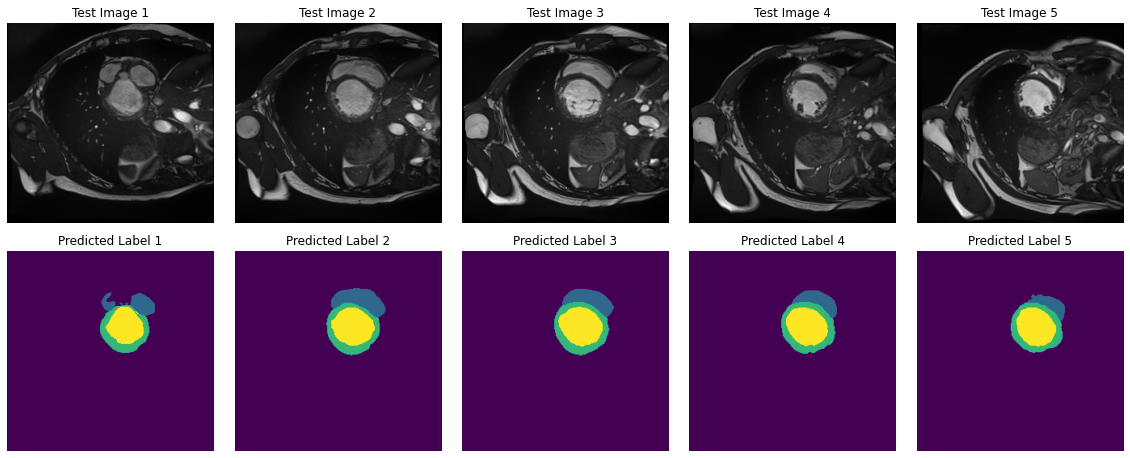

In [ ]:
#visualizing the predicted results
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted

test_img_name = os.listdir(test_dir)[np.random.randint(1,10)]
test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,:,:5]
predicted_img_name = test_img_name[:test_img_name.find('_0000.nii.gz')]+'.nii.gz'

print(result_dir)
result_dir_with_predts = os.path.join(result_dir,'predts')
print(result_dir_with_predts)

predicted_label = np.array(nib.load(os.path.join(result_dir_with_predts,predicted_img_name)).dataobj)[:,:,:5]
print('Test Image Shape: ',test_img.shape)
print("Predicted Image Shape:",predicted_label.shape)

max_rows = 2
max_cols = test_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
for idx in range(max_cols):
    axes[0, idx].axis("off") 
    axes[0, idx].set_title('Test Image ' + str(idx+1))
    axes[0, idx].imshow(test_img[:,:,idx], cmap="gray")
for idx in range(max_cols):    
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Predicted Label ' + str(idx+1))
    axes[1, idx].imshow(predicted_label[:,:,idx])
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

Vergleich: Test image mit predicted label und ground truth label

test_label_name = patient047_frame01_gt.nii.gz
Test Label Shape: (256, 208, 5)
/content/drive/My Drive/Colab Notebooks/nnUNet_Results_Folder/nnUNet_Prediction_Results/Task901_ACDC
/content/drive/My Drive/Colab Notebooks/nnUNet_Results_Folder/nnUNet_Prediction_Results/Task901_ACDC/predts
test_img_name = patient041_frame01_0000.nii.gz
Test Image Shape:  (154, 224, 5)
Predicted Image Shape: (154, 224, 5)


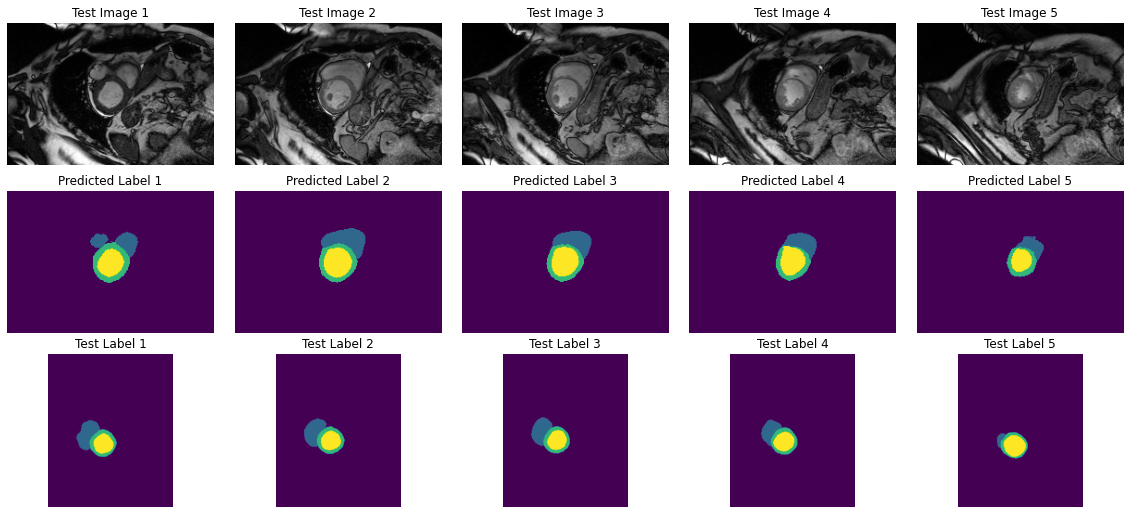

In [ ]:
# TODO: Neuen Ordner mit den Test-Labels von patient 41...50 erstellen. Z. B. "testTs"
# Dann hier direkt darunter die Labels aus diesem Ordner einbinden

# test_label_name = test_label_name[:test_label_name.find('_0000.nii.gz')]+'.nii.gz'
# test_label = np.array(nib.load(os.path.join(train_label_dir,train_label_name)).dataobj)[:,:,:5]

# print(train_img.shape,train_label.shape)

GlobalRandInt = np.random.randint(1,10)

test_label_dir = '/content/drive/My Drive/Colab Notebooks/ACDC-TestLabels/labelsTs'

test_label_name = os.listdir(test_label_dir)[GlobalRandInt]
print(f"test_label_name = {test_label_name}")
test_label = np.array(nib.load(os.path.join(test_label_dir,test_label_name)).dataobj)[:,:,:5]

print(f"Test Label Shape: {test_label.shape}")




#visualizing the predicted results
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted

test_img_name = os.listdir(test_dir)[GlobalRandInt]
test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,:,:5]
predicted_img_name = test_img_name[:test_img_name.find('_0000.nii.gz')]+'.nii.gz'

print(result_dir)
result_dir_with_predts = os.path.join(result_dir,'predts')
print(result_dir_with_predts)
print(f"test_img_name = {test_img_name}")

predicted_label = np.array(nib.load(os.path.join(result_dir_with_predts,predicted_img_name)).dataobj)[:,:,:5]
print('Test Image Shape: ',test_img.shape)
print("Predicted Image Shape:",predicted_label.shape)

max_rows = 3
max_cols = test_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,9))
# Erste Zeile für test images
for idx in range(max_cols):
    axes[0, idx].axis("off") 
    axes[0, idx].set_title('Test Image ' + str(idx+1))
    axes[0, idx].imshow(test_img[:,:,idx], cmap="gray")
# Zweite Zeile für predicted labels
for idx in range(max_cols):    
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Predicted Label ' + str(idx+1))
    axes[1, idx].imshow(predicted_label[:,:,idx])
# Dritte Zeile für test labels (ground truth)
for idx in range(max_cols):    
    axes[2, idx].axis("off")
    axes[2, idx].set_title('Test Label ' + str(idx+1))
    axes[2, idx].imshow(test_label[:,:,idx])
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()